In [1]:
import cv2
import matplotlib.pyplot as plt

import numpy as np

import os

In [2]:
# example video
video_dir = "../data/v1/video"
video_name = "a_f_3_F_H.mp4"
video_path = os.path.join(video_dir, video_name)

### Preview

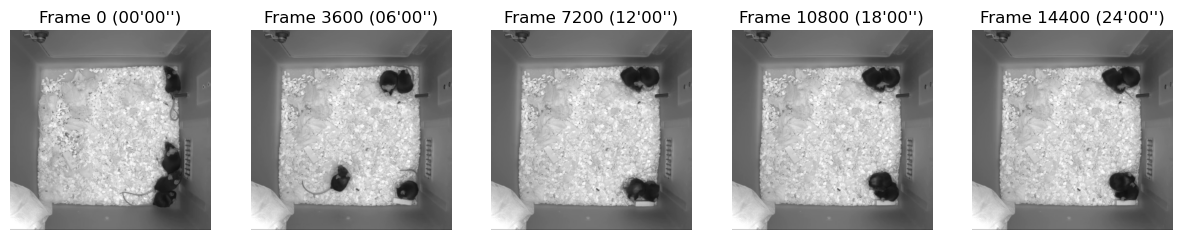

In [3]:
k = 6
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interval = total_frames // (k-1)
frames = []
for i in range(0, total_frames, interval):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    if len(frames) == k-1:
        break
cap.release()

fig, axes = plt.subplots(1, k-1, figsize=(15, 5))
for idx, frame in enumerate(frames):
    axes[idx].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[idx].axis('off')
    frame_number = idx * interval
    minutes = int(frame_number // (fps * 60))
    seconds = int((frame_number % (fps * 60)) // fps)
    axes[idx].set_title(f"Frame {idx * interval} ({minutes:02}'{seconds:02}'')")
plt.show()

### Background

Preliminary analysis for background removal by median filtering.

In [4]:
def get_background(video_path: str, quantile: float, n = 40) -> np.ndarray:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, frame_count+1, num=n, dtype=int)
    #frame_indices = frame_indices[1:-1]  # Exclude the first and last frame
    background_frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        background_frames.append(frame)
    cap.release()
    background_frames = np.array(background_frames)
    background = np.quantile(background_frames, quantile, axis=0).astype(np.uint8)

    return background

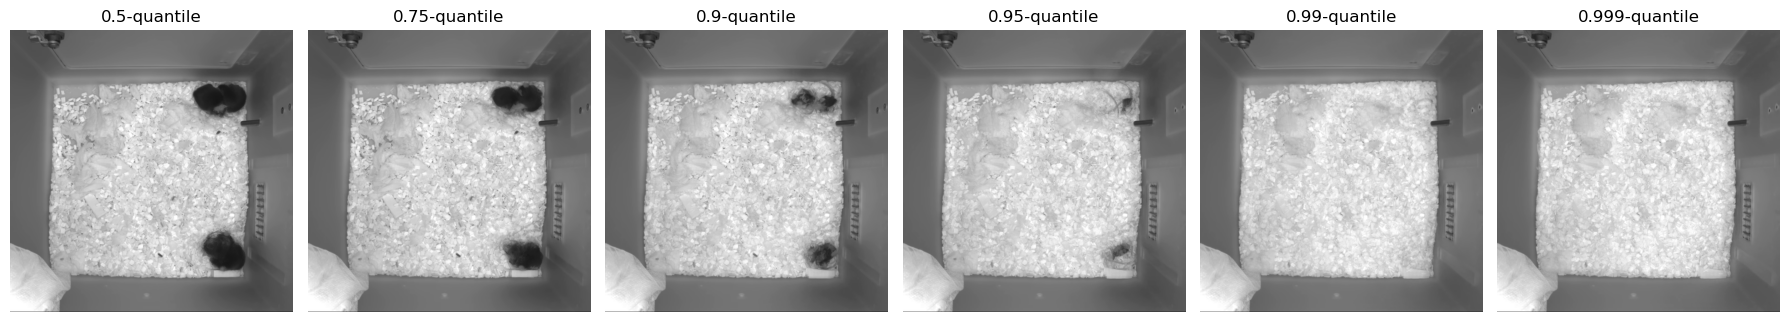

In [5]:
quantiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]

fig, axes = plt.subplots(1, len(quantiles), figsize=(18, 4))
backgrounds = {}
for i, q in enumerate(quantiles):
    background = get_background(video_path, quantile=q)
    axes[i].imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"{q}-quantile")
    backgrounds[q] = background.astype(np.int16)

plt.tight_layout()
plt.show()

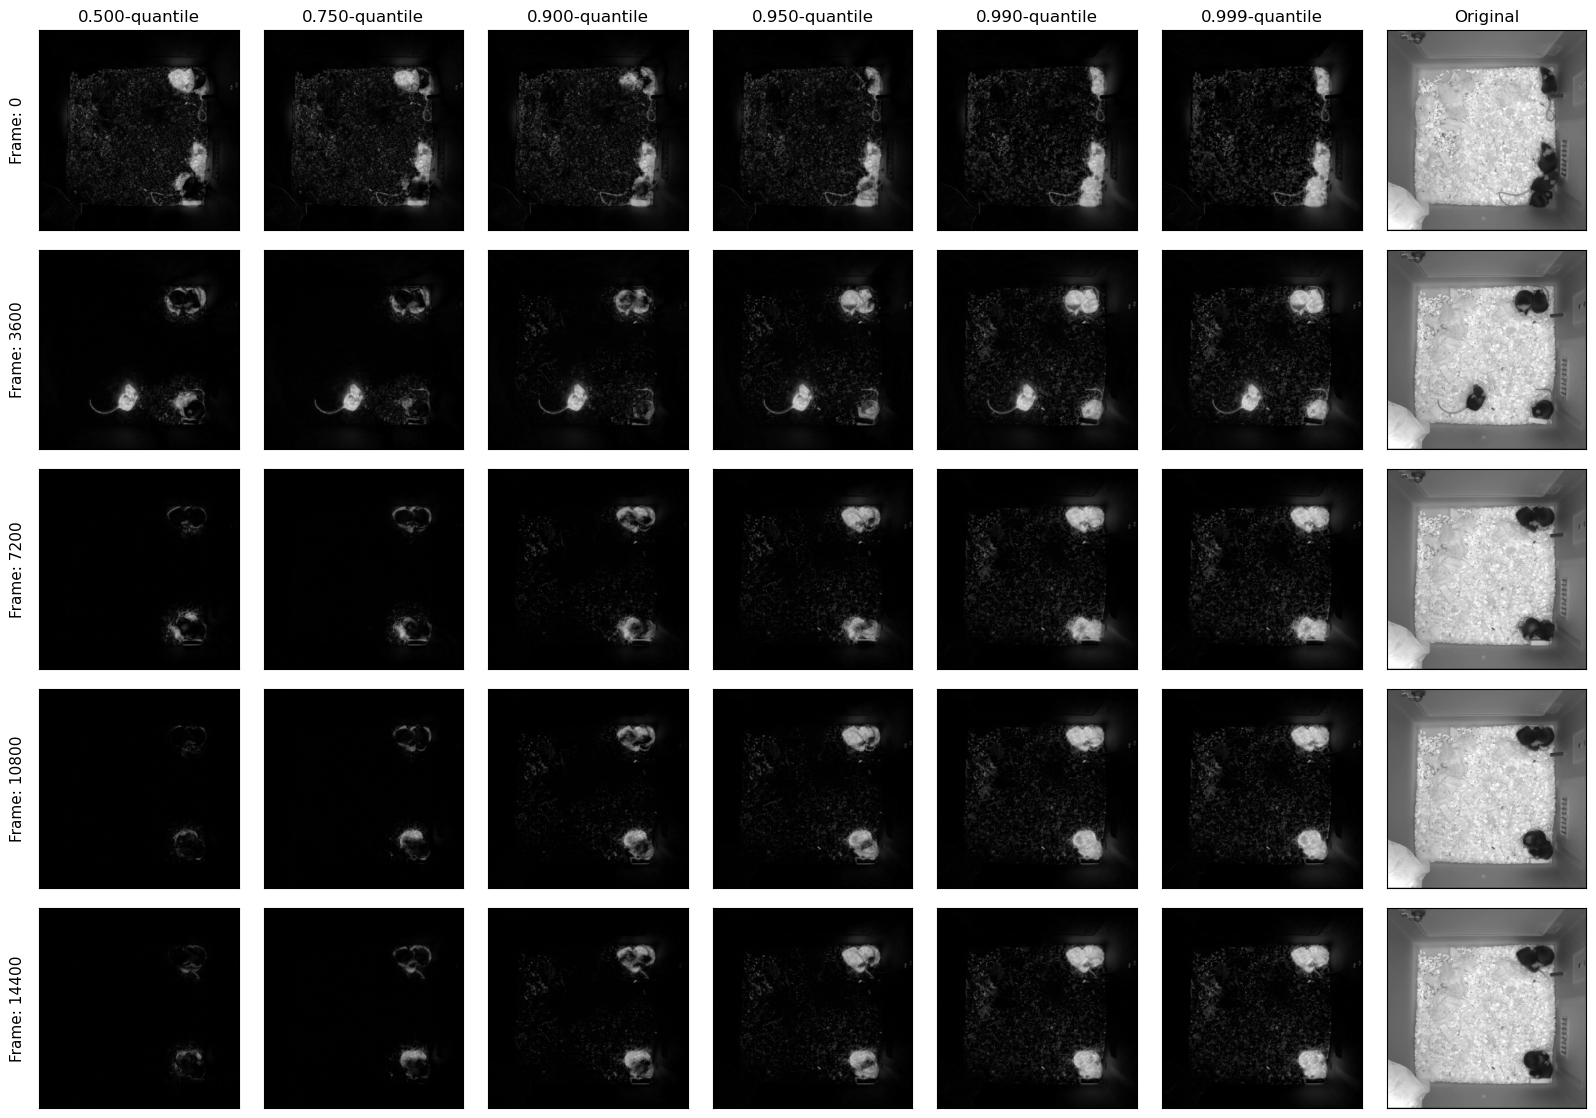

In [6]:
k = 6  
quantiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
n_cols = len(quantiles) + 1  # Last column for original

fig, axes = plt.subplots(len(frames), n_cols, figsize=(2.8 * n_cols, 2.8 * len(frames)))

for i, frame in enumerate(frames):
    for j in range(n_cols):
        ax = axes[i, j] if len(frames) > 1 else axes[j]
        
        if j < len(quantiles):
            q = quantiles[j]
            diff = np.clip(np.abs(frame - backgrounds[q]), 0, 255).astype(np.uint8)
            rgb_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)
            ax.imshow(rgb_diff)
            if i == 0:
                ax.set_title(f"{q:.3f}-quantile", fontsize=12)
        else:
            rgb_img = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB)
            ax.imshow(rgb_img)
            if i == 0:
                ax.set_title("Original", fontsize=12)

        ax.set_xticks([])
        ax.set_yticks([])

        if j == 0:
            ax.set_ylabel(f"Frame: {i * interval}", fontsize=11, labelpad=10)

plt.subplots_adjust(wspace=0.02, hspace=0.1, left=0.10)
plt.savefig("results/background.png", dpi=300, bbox_inches='tight')
plt.show()

## Tracking

_Object detection_: Easy-Medium (the background is not static, but the mice are clearly distinguishable)

_Identification_: Very Hard (strong occlusion, long context required, no simple rule)